# 任务3：LSTM网络实现RNN写作生成

**任务要求：利用LSTM网络实现RNN的莎士比亚风格文本写作生成。**  
**数据: shakespeare.txt**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
use_gpu = True if torch.cuda.is_available() else False
print('Use GPU:', use_gpu)

Use GPU: False


## 1. 加载文本数据

加载训练文本数据及字符集

In [3]:
all_characters = string.printable
n_characters = len(all_characters)
print('characters num:', n_characters)
print(all_characters)

file = unidecode.unidecode(open('./data/shakespeare.txt').read())
file_len = len(file)
print('file length:', file_len)

characters num: 100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

file length: 1115394


### 随机文本块

In [4]:
chunk_len = 500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index: end_index]

print(random_chunk())

he precious safety of my prince,
And free from other misbegotten hate,
Come I appellant to this princely presence.
Now, Thomas Mowbray, do I turn to thee,
And mark my greeting well; for what I speak
My body shall make good upon this earth,
Or my divine soul answer it in heaven.
Thou art a traitor and a miscreant,
Too good to be so and too bad to live,
Since the more fair and crystal is the sky,
The uglier seem the clouds that in it fly.
Once more, the more to aggravate the note,
With a foul trait


### 随机数据-标签对

In [5]:
def char_tensor(string):
    n = len(string)
    t = torch.zeros(n).long()
    for i in range(n):
        t[i] = all_characters.index(string[i])
    return Variable(t)

print(char_tensor('(abcdef,ABCDEF).'))

tensor([69, 10, 11, 12, 13, 14, 15, 73, 36, 37, 38, 39, 40, 41, 70, 75])


In [6]:
def random_training_set():
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

random_training_set()

(tensor([28, 94, 24, 15, 94, 17, 24, 27, 28, 14, 28, 94, 18, 23, 94, 29, 17, 14,
         94, 23, 18, 16, 17, 29, 73, 96, 36, 23, 13, 94, 11, 10, 20, 14, 28, 94,
         29, 17, 14, 94, 14, 21, 15, 21, 24, 12, 20, 28, 94, 18, 23, 94, 15, 24,
         30, 21, 94, 28, 21, 30, 29, 29, 18, 28, 17, 94, 17, 10, 18, 27, 28, 73,
         96, 58, 17, 18, 12, 17, 94, 24, 23, 12, 14, 94, 30, 23, 29, 10, 23, 16,
         21, 14, 13, 73, 94, 22, 30, 12, 17, 94, 22, 18, 28, 15, 24, 27, 29, 30,
         23, 14, 94, 11, 24, 13, 14, 28, 77, 96, 55, 17, 18, 28, 94, 18, 28, 94,
         29, 17, 14, 94, 17, 10, 16, 73, 94, 32, 17, 14, 23, 94, 22, 10, 18, 13,
         28, 94, 21, 18, 14, 94, 24, 23, 94, 29, 17, 14, 18, 27, 94, 11, 10, 12,
         20, 28, 73, 96, 55, 17, 10, 29, 94, 25, 27, 14, 28, 28, 14, 28, 94, 29,
         17, 14, 22, 94, 10, 23, 13, 94, 21, 14, 10, 27, 23, 28, 94, 29, 17, 14,
         22, 94, 15, 18, 27, 28, 29, 94, 29, 24, 94, 11, 14, 10, 27, 73, 96, 48,
         10, 20, 18, 23, 16,

## 2. RNN模型

利用PyTorch构建RNN模型类，内部包括Embedding层、LSTM、FC层

In [7]:
''' 请在下方编写RNN模型类 '''
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size,hidden_size)
        self.lstm = nn.LSTM(hidden_size,hidden_size,num_layers,batch_first = True)
        self.fc = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, inputs, hidden):
        x=self.embedding(inputs)
        outputs,hidden=self.lstm(x,hidden)
        outputs = outputs[:,-1,:]
        outputs = self.fc(outputs)
        outputs = self.softmax(outputs)
        return outputs, hidden
    
    def init_hidden(self):
        h0, c0 = Variable(torch.zeros(self.num_layers,1,self.hidden_size)),Variable(torch.zeros(self.num_layers,1,self.hidden_size))
        return h0, c0

## 3. 训练函数

In [8]:
def train(inputs, target):
    h, c = rnn.init_hidden()
    if use_gpu:
        inputs = inputs.cuda()
        target = target.cuda()
        h, c = h.cuda(), c.cuda()
    hidden = h, c
    
    loss = 0
    for i in range(len(inputs)-1):
        ''' 请在下方编写rnn模型输出，及loss累加代码'''
        x=Variable(torch.LongTensor([inputs[i]]).unsqueeze(0))
        y=Variable(torch.LongTensor([inputs[i+1]]))
        outputs,hidden=rnn(x,hidden)
        loss+=criterion(outputs,y)
    loss = 1.0*loss/len(inputs)
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data.item()/len(inputs)

## 4. 文本生成测试函数

In [9]:
def test(prime_str='A', predict_len=100, temperature=0.8):
    h, c = rnn.init_hidden()
    prime_input = char_tensor(prime_str)
    print(prime_str)
    if use_gpu:
        h, c = h.cuda(), c.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str
    
    for i in range(len(prime_str)-1):
        
        pk=Variable(torch.LongTensor([prime_input[i]]).unsqueeze(0))
        _, (h, c) = rnn(pk, (h, c))
    inputs = Variable(torch.LongTensor([prime_input[-1]]).unsqueeze(0))
    for p in range(predict_len):
        if use_gpu:
            inputs = inputs.cuda()
        output, (h, c) = rnn(inputs, (h, c))
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inputs = char_tensor(predicted_char).unsqueeze(0)
    
    return predicted

## 5. 模型训练

#### 超参数

In [10]:
''' 请自行设定相关参数 '''
epoch_num = 5000  # 1000~10000
print_every = 100
plot_every = 10
hidden_size = 100
num_layers = 1
lr = 0.005

#### 模型、优化器、损失函数

In [11]:
# RNN模型
rnn = RNN(n_characters, hidden_size, n_characters, num_layers)
if use_gpu:
    rnn = rnn.cuda()
print(rnn)

RNN(
  (embedding): Embedding(100, 100)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=100, bias=True)
  (softmax): LogSoftmax()
)


In [12]:
# 优化器
''' 请在下方编写Adam优化器定义的代码 '''
from torch import optim
optimizer = optim.Adam(rnn.parameters(),lr = 0.001)
print(optimizer)

# 损失函数
''' 请在下方编写交叉熵损失函数定义的代码 '''
criterion = nn.CrossEntropyLoss()
print(criterion)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
CrossEntropyLoss()


#### 模型训练

In [13]:
time_start = time.time()
evaluate = True  # 可设置为False，训练过程中不评估
loss_list = []
loss_avg = 0

for epoch in range(1, epoch_num+1):
    inputs, targets = random_training_set()
    loss = train(inputs, targets)
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[Time: %ds  Epoch: %d (%d%%)  Loss: %.4f]'%(int(time.time()-time_start), epoch, epoch/epoch_num*100, loss))
        if evaluate:
            pred_text = test('Th', 200)
            print(pred_text, '\n')
        
    if epoch % plot_every == 0:
        loss_list.append(loss_avg/plot_every)
        loss_avg = 0

[Time: 84s  Epoch: 100 (2%)  Loss: 0.0055]
Th
Thef bes the buse hethitecu d awleve tko tous ie t atyuth d, shity at woou vou wule the  he'd ot ere'a ran
do herto oo th isliem wsad meve il aerps

 chow, oror wounng:
beasel
t ohdu t you there i teren 

[Time: 168s  Epoch: 200 (4%)  Loss: 0.0046]
Th
Ther thow rather henkeg yomed hoth oner, ponrtes touheres do whe :it I tho this pue yot the nome bee theve lusind the fy I I a?
I oll hend is ras; ereigen sale that sto, g, at hingond vo
e o'coh akee la 

[Time: 255s  Epoch: 300 (6%)  Loss: 0.0046]
Th
ThRut lle dou, havemen of tou! sath ownd win stingh iid hid mailld o th; and inter thent, bate his ver thes to mee ony that you thamk sase in, the reoes ugure to asterde tha, wermrand ald fatin bane por 

[Time: 346s  Epoch: 400 (8%)  Loss: 0.0044]
Th
Ths my wate mastt me bowe blove till
I nomove,
I the heasd fo bus to sheree houd man reat ane harteanh ome,
Whar sor hare Kame meak fand wind I wensp ave cils dere me,
Buk siss
Locy,
Af ssto thoulle

[Time: 2868s  Epoch: 3400 (68%)  Loss: 0.0035]
Th
The deen thou hading hath the have wors
And stone you are that peak 't by maswor,
And lived of lect ever her
Furse, thy door your have dighs proos thou quese,
Will as the priswer, all the beath, ising a 

[Time: 2951s  Epoch: 3500 (70%)  Loss: 0.0033]
Th
Thine it him his sheed with of duss,
Ttince Pveatoreps is chal have dother from himsen for time
and your be fronce here your wors and five are make,
Hou word him ever whith a no himsee a canten
On the r 

[Time: 3032s  Epoch: 3600 (72%)  Loss: 0.0034]
Th
That knoth for shour, thy henes was worse,
Be the to the befor the gover's langers conters all the to the ba
To virtuse blook, I lam is my fears
So so say's stormo, that with deares, from wearce;
Whave  

[Time: 3111s  Epoch: 3700 (74%)  Loss: 0.0030]
Th
Thy abour her manged mars
Don not your tand lame ownest Mimun
she frite agan this here his to thy clastend mare to doge has,
The compting sould my all the consuce,
Whell me foired.

ANd

## 6. 训练Loss曲线

绘制训练过程中的Loss曲线

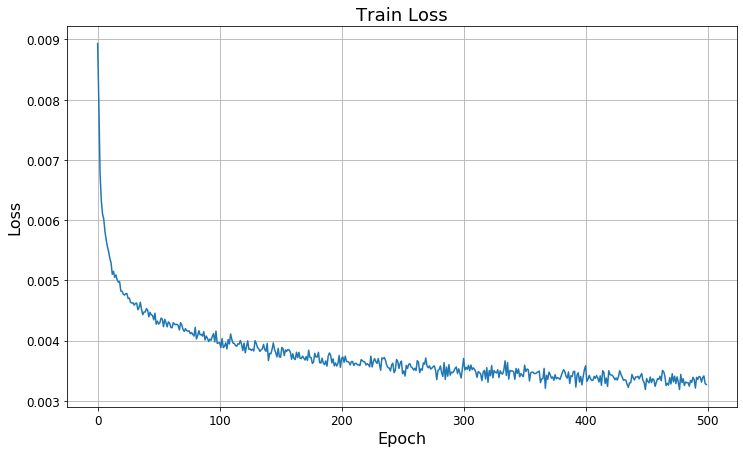

In [14]:
plt.figure(figsize=(12, 7))
plt.plot(loss_list)
plt.title('Train Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

## 7. 测试

自定义初始字符和文本长度以生成文本

In [15]:
test_text = test('Th', 1000, 0.8)
print(test_text)

Th
Then: your flaw sitch with the to the cheams,
To will we shan of I the but them the wore.

First Serving:
Come, who he some stull, ant this compot preads your but,
And his man be sore you must, he the brother.

MONTISA:
And that we by the have denre talks there,
Thou you heaven to the plashed your ham not uncempen:
Fown the comub and her done.
I bedens in the nevery but thou host me ain.

DUCHESS OF YORK:
It with ercly, besions apen this friness them herm.

LADY GBEVROTES:
Come with the are them the prove and thy a beans.

AUTONIUS:
I not winles ands me then and therethere of we
Cominian my the pistrerian our cithing the kings
Sut your comes, fentain, the supjuch will stave,
Intelf whom the havence doon end and a for for
She honged with preathered by you give the speak the biltan.

TRAMINA:
If but yet attere holeful the rester
There fefreth not, posar of my pleat.

CAMILLUS:
And as we ligtorn of the bant the poster buth your of go she?
And dewild not stancent bont of me, whas I
And 

In [16]:
test_text = test('Wh', 1000, 0.8)
print(test_text)

Wh
Whome we could go thesters that's houghts grace when
The to the thou own the souders and inier,
Of the not -rethe sut chere not of heardian.

LEONTES:
I was denerfouthen murning hearthless to have me,
And the good he to stake mine you met faces?

Secreterry:
Now; for this same in your have the
be stand an the  and why many blood she betching pett of eveldanion.

TRANIO:
By 's there hose you can and recurst dough you come;
lord, and the hole themer the hearther. I
And it pace pirto how have by bease I hougher
Why with you a me thither lord!
How be some of hears be it in the farreds and doed
But when me in a best all common one rustain?

SICHARD III:
That when the graves of I thou are unture
My say his malt of done, that have you ruty from heart,
In he stome the controves feel deats Duke therered fourent
The had I would me the all mine to he,
Be houl the ging of does usethinger,
The worn be now, what, wasse ason envise
To pray leave stither the usteen we hacknom.

PRONCES:
Thy agate g